In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.decomposition import NMF

In [2]:
my_songs = pd.read_parquet('./datasets/cleaned/music-recommendation-system/liked/personal-playlists.parquet')

# check how many duplicated songs
print(my_songs.shape)
print(my_songs[my_songs.duplicated(subset=['id'])].shape)

(226, 23)
(18, 23)


In [3]:
# remove duplicated songs
no_dup_songs = my_songs.drop_duplicates(subset=['id'])

print(no_dup_songs.shape)
print(no_dup_songs[no_dup_songs.duplicated(subset=['id'])].shape)

(208, 23)
(0, 23)


In [4]:
# exclude columns with object type and a column called 'like'
df = no_dup_songs.select_dtypes(exclude=['object']).drop('like', axis=1)
df.head()

,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,listen
0,88,0.639,0.7230,7,-6.462,0,0.0532,0.511,0.000000,0.167,0.878,136.872,187558,4,1
1,83,0.472,0.5180,8,-7.379,1,0.0510,0.383,0.127000,0.289,0.154,147.805,211667,4,1
2,68,0.848,0.3640,11,-10.058,1,0.0637,0.697,0.005290,0.140,0.569,137.541,214160,4,1
3,61,0.361,0.0203,11,-25.064,1,0.0555,0.925,0.002240,0.114,0.351,76.621,123320,4,1
4,82,0.440,0.3170,8,-9.258,1,0.0531,0.891,0.000005,0.141,0.268,169.914,233456,3,1


In [5]:
reconstruction_errors = []
dimensions = range(2, df.columns.size + 1)

# create an elbow plot to determine the optimal number of dimensions
for dimension in dimensions:
  pipeline = make_pipeline(
    MinMaxScaler(),
    NMF(
      n_components=dimension,
      max_iter=10000,
    ),
    Normalizer()
  )
  pipeline.fit(df)
  reconstruction_errors.append(pipeline.named_steps['nmf'].reconstruction_err_)

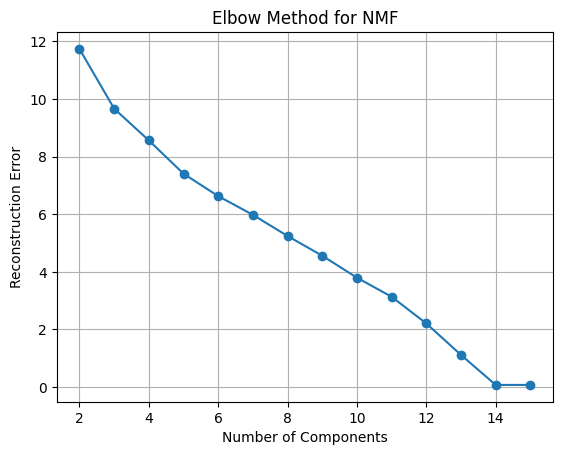

In [6]:
plt.plot(dimensions, reconstruction_errors, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Reconstruction Error')
plt.title('Elbow Method for NMF')
plt.grid(True)
plt.show()

In [7]:
pipeline = make_pipeline(
  MinMaxScaler(), 
  NMF(
    n_components=7,
    init='random',
    random_state=0,
    max_iter=10000
  ),
  Normalizer()
)
features = pipeline.fit_transform(df)

In [8]:
# get components of NMF model out of one of the steps of the pipeline
components = pipeline.named_steps['nmf'].components_

categories = pd.DataFrame(components, columns=df.columns.values)

# iterate through each category
for i in range(0, len(categories)):
    # sort the values in each category from highest to lowest, and get the name of the top 10
    print(f"Category {i}: {categories.iloc[i].sort_values(ascending=False).index.values[0]}")
    # print('Category: ', categories.iloc[i]
    # print(categories.iloc[i].sort_values(ascending=False)[:10])
    # print('\n')

Category 0: popularity
Category 1: mode
Category 2: instrumentalness
Category 3: key
Category 4: speechiness
Category 5: valence
Category 6: acousticness


In [9]:
cat = [
  {
    "value": 0,
    "label": "popularity"
  },
  {
    "value": 1,
    "label": "mode"
  },
  {
    "value": 2,
    "label": "instrumentalness"
  },
  {
    "value": 3,
    "label": "key"
  },
  {
    "value": 4,
    "label": "speechiness"
  },
  {
    "value": 5,
    "label": "valence"
  },
  {
    "value": 6,
    "label": "acousticness"
  }
]

In [10]:
processed_songs = pd.DataFrame(features, index=no_dup_songs['title'])

wanted_song = processed_songs.loc['La La Lost You - Acoustic Version']

In [11]:
processed_songs[:5]

,0,1,2,3,4,5,6
title,,,,,,,
Moonlight,0.687819,0.000000,0.022677,0.420572,0.037392,0.461799,0.367225
Die For You,0.795659,0.419812,0.084564,0.367031,0.034901,0.063033,0.208879
Traingazing,0.421927,0.482856,0.007271,0.598761,0.072504,0.241463,0.408288
See You Later,0.000000,0.502542,0.000000,0.633809,0.000000,0.061599,0.584759
Glimpse of Us,0.544596,0.482510,0.030081,0.428721,0.071149,0.001509,0.529932


In [12]:
# get the first row in processed_songs
print(processed_songs.iloc[0])

0    0.687819
1    0.000000
2    0.022677
3    0.420572
4    0.037392
5    0.461799
6    0.367225
Name: Moonlight, dtype: float64


In [13]:
labels = []
# iterate through a dataframe
for i in range(len(processed_songs)):
  labels.append(
    np.argmax(processed_songs.iloc[i])
  )

labels[:5]

[0, 0, 3, 3, 0]

In [14]:
for i in range(0, 7):
  print(cat[i].get('label'))

popularity
mode
instrumentalness
key
speechiness
valence
acousticness


In [15]:
songs_labels = pd.DataFrame(labels, index=no_dup_songs.title, columns=["label"])

# cat_names = []
# for i in range(songs_labels.shape[0]):
#   cat_names.append(cat[songs_labels.iloc[i,0]].get('label'))
# songs_labels["category"] = cat_names

# simplify the code above
songs_labels['category'] = [cat[songs_labels.iloc[i,0]].get('label') for i in range(songs_labels.shape[0])]

songs_labels.head(20)

,label,category
title,,
Moonlight,0,popularity
Die For You,0,popularity
Traingazing,3,key
See You Later,3,key
Glimpse of Us,0,popularity
La La Lost You - Acoustic Version,6,acousticness
blue,3,key
Surf,0,popularity
Good News,0,popularity


In [16]:
songs_labels['category'].value_counts()

popularity          113
mode                 33
instrumentalness     23
key                  17
acousticness         14
valence               7
speechiness           1
Name: category, dtype: int64

In [17]:
recommended_songs = processed_songs.dot(wanted_song)
print(recommended_songs.nlargest(20))

title
La La Lost You - Acoustic Version                                                               1.000000
La vie en rose (feat. Cécile McLorin Salvant)                                                   0.990216
三人遊                                                                                             0.985808
It's Been A Long, Long Time                                                                     0.966189
Le Festin                                                                                       0.965082
No Reason                                                                                       0.957401
太陽                                                                                              0.955159
L’Amour, Les Baguettes, Paris                                                                   0.952642
i love you                                                                                      0.949393
Until I Found You (Sped Up) - Heaven When I Held 

In [18]:
recommended_songs[recommended_songs < 0.5][:5]

title
Idea 10 (Slowed & Reverb)    0.491430
Idea 22 (Slowed + Reverb)    0.490577
Idea 10 (Sped Up)            0.464278
Solas (Sped Up)              0.461507
dream river.                 0.453827
dtype: float64

In [19]:
recommended_songs[recommended_songs < 0.8].shape

(170,)

In [20]:
no_dup_songs.head()

,id,title,artist(s),popularity,danceability,energy,key,loudness,mode,speechiness,...,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature,listen,like
0,2i2gDpKKWjvnRTOZRhaPh2,Moonlight,Kali Uchis,88,0.639,0.7230,7,-6.462,0,0.0532,...,0.878,136.872,audio_features,spotify:track:2i2gDpKKWjvnRTOZRhaPh2,https://api.spotify.com/v1/tracks/2i2gDpKKWjvn...,https://api.spotify.com/v1/audio-analysis/2i2g...,187558,4,1,1
1,26hOm7dTtBi0TdpDGl141t,Die For You,Joji,83,0.472,0.5180,8,-7.379,1,0.0510,...,0.154,147.805,audio_features,spotify:track:26hOm7dTtBi0TdpDGl141t,https://api.spotify.com/v1/tracks/26hOm7dTtBi0...,https://api.spotify.com/v1/audio-analysis/26hO...,211667,4,1,1
2,0edtKj1oW6rJ9f4wRtLPPH,Traingazing,Sam Wills,68,0.848,0.3640,11,-10.058,1,0.0637,...,0.569,137.541,audio_features,spotify:track:0edtKj1oW6rJ9f4wRtLPPH,https://api.spotify.com/v1/tracks/0edtKj1oW6rJ...,https://api.spotify.com/v1/audio-analysis/0edt...,214160,4,1,1
3,1xHrPq8WvLKiO6lT94Ks2F,See You Later,EKKSTACY,61,0.361,0.0203,11,-25.064,1,0.0555,...,0.351,76.621,audio_features,spotify:track:1xHrPq8WvLKiO6lT94Ks2F,https://api.spotify.com/v1/tracks/1xHrPq8WvLKi...,https://api.spotify.com/v1/audio-analysis/1xHr...,123320,4,1,1
4,4ewazQLXFTDC8XvCbhvtXs,Glimpse of Us,Joji,82,0.440,0.3170,8,-9.258,1,0.0531,...,0.268,169.914,audio_features,spotify:track:4ewazQLXFTDC8XvCbhvtXs,https://api.spotify.com/v1/tracks/4ewazQLXFTDC...,https://api.spotify.com/v1/audio-analysis/4ewa...,233456,3,1,1


In [21]:
wanted_songs = no_dup_songs['title'].head().values
recommended_songs = []

for song in wanted_songs:
  # for each song, get the top 10 most similar songs
  similar_songs = processed_songs.dot(processed_songs.loc[song])
  # append the top 10 most similar songs to the recommended_songs list
  recommended_songs.append(similar_songs.nlargest(10).index.values)

print(wanted_songs)

for songs in recommended_songs:
  print(songs)

['Moonlight' 'Die For You' 'Traingazing' 'See You Later' 'Glimpse of Us']
['Moonlight' 'Si Te Preguntan...' 'What Do You Mean?' 'Loser'
 'Make You Say' 'Love$ick (feat. A$AP Rocky)'
 'Everybody Dies In Their Nightmares'
 'Fly Me To The Moon - 2008 Remastered'
 'Just the Two of Us (feat. Bill Withers)' 'You']
['Die For You' 'Love Me Like You Do - From "Fifty Shades Of Grey"'
 "Ballin' (with Roddy Ricch)" 'Passionfruit' 'Weekend (feat. Miguel)'
 'Here With Me' 'BUTTERFLY EFFECT' 'goosebumps' 'Leave The Door Open'
 'You Right - Extended']
['Traingazing' "I'm Not The Only One - Sped Up" 'FaceTime'
 'Until I Found You (with Em Beihold) - Em Beihold Version' 'La mer'
 'Wonderful tonight' '愛愛愛' 'Love Song' '為妳寫的歌' '紅豆']
['See You Later' '象牙舟' 'What A Wonderful World' 'La Vie en rose'
 'ocean eyes - sped up' 'La mer' 'Until I Found You - Piano Version'
 'good days - sped up' 'Traingazing' 'Singalongsong']
['Glimpse of Us' 'Until I Found You - Piano Version'
 'Until I Found You (with Em Beihold